# interface: 從協定到 ABC
## 抽象類別代表介面
* 代表 duck typeing 的動態協定，到使介面更明確，並驗證實作一致的抽象基礎類別(ABC)
* duck typeing 協定他是普通介面思維方式是 ABC 法定程式(formality) 與型態檢查


1. 專門討論 ABC 從常見用途當實作介面將他們當成父類別
2. 何時 ABC 會檢查子類別是否符合他所定義的介面，註冊機制如何壤開發者不需要繼承可以宣稱某類別實作一個介面
3. 編寫 ABC 自動識別符合介面不需要繼承或註冊


## 介面與協定
* 每個類別都有介面包含自己實作或是從類別繼承通用屬性包含特殊方法
* 受保護與私有屬性不是介面一部分
* 公有屬性成為物件一部分，因為資料屬性可以改成實作 getter/setter 邏輯，而不會破壞使用一般obj.attr用戶端程式碼
* 補充介面定義：某物件公用方法子集合，在系統可以發揮具體作用就是協定（一群方法集合，可以扮演一個角色的介面）

```
#範例9-2
class Vector2d:
    typecode = 'd'  # <1>

    def __init__(self, x, y):
        self.x = float(x)    # <2>
        self.y = float(y)

    def __iter__(self):
        return (i for i in (self.x, self.y))  # <3>
```

```
# 
class Vector2d:
    typecode = 'd'

    def __init__(self, x, y):
        self.__x = float(x)
        self.__y = float(y)

    @property
    def x(self):
        return self.__x

    @property
    def y(self):
        return self.__y
        
    def __iter__(self):
        return (i for i in (self.x, self.y))  # <3>
```

範例上下差異為改寫成唯讀特性，基本要素不變

## 挖掘序列
* 實作序列協定一個方法 `__getitem__`
* 沒有繼承 abc.sequemce 也可以存取及迭代與 in 運算子

In [3]:
class Foo:
    def __getitem__(self, pos):
        return range(0, 30, 10)[pos]
F = Foo()
F[1]

10

In [6]:
f = Foo()
for i in f: print(i)

0
10
20


In [7]:
20 in F

True

In [8]:
15 in F 

False

In [9]:
dir(F)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__']

因為序列協定關係沒有 __iter__與 __contains__ 方法也可以讓 in 運算子工作及迭代物件

# Monkey patching 在執行階段實作協定

In [11]:
# shuffle 函式標準用法
from random import shuffle
l = list(range(10))
shuffle(l)
l

[1, 8, 9, 2, 0, 6, 3, 4, 5, 7]

In [12]:
from random import shuffle
import collections

# namedtuple define Card
Card = collections.namedtuple('Card', ['rank', 'suit'])

class FrenchDeck:
    ranks = [str(n) for n in range(2, 11)] + list('JQKA')
    suits = 'spades diamonds clubs hearts'.split()

    # 起始化牌堆
    def __init__(self):
        self._cards = [Card(rank, suit) for suit in self.suits
                                        for rank in self.ranks]
    # 用 len 計算 list 個數
    def __len__(self):
        return len(self._cards)
    # 從 postition 去找牌花色及數字
    def __getitem__(self, position):
        return self._cards[position]


In [13]:
deck = FrenchDeck()
shuffle(deck)

TypeError: 'FrenchDeck' object does not support item assignment

In [14]:
# Monkey patching
def set_card(deck, position, card):
    deck._cards[position] = card


In [15]:
FrenchDeck.__setitem__ = set_card

In [16]:
shuffle(deck)

In [17]:
deck[:5]

[Card(rank='7', suit='clubs'),
 Card(rank='9', suit='spades'),
 Card(rank='10', suit='spades'),
 Card(rank='K', suit='clubs'),
 Card(rank='J', suit='clubs')]

## 將 ABC 子類別化
利用現成 ABC collections.MutableSequence 將 FrenchDeck2 明確宣告為 collections.MutableSequence 子類別

In [21]:
from collections.abc import MutableSequence

Card = collections.namedtuple('Card', ['rank', 'suit'])

class FrenchDeck2(collections.MutableSequence):
    ranks = [str(n) for n in range(2, 11)] + list('JQKA')
    suits = 'spades diamonds clubs hearts'.split()

    def __init__(self):
        self._cards = [Card(rank, suit) for suit in self.suits
                                        for rank in self.ranks]

    def __len__(self):
        return len(self._cards)

    def __getitem__(self, position):
        return self._cards[position]

    def __setitem__(self, position, value):  # <1> 要成為 MutableSequence 子類別必須實作 __setitem__ 方法(洗牌用)
        self._cards[position] = value

    def __delitem__(self, position):  # <2> 要成為 MutableSequence 子類別必須實作 __delitem__ 方法
        del self._cards[position]

    def insert(self, position, value):  # <3> 要成為 MutableSequence 子類別必須實作 insert 方法
        self._cards.insert(position, value)

In [27]:
deck = FrenchDeck2()
shuffle(deck)
deck[:5]

[Card(rank='5', suit='hearts'),
 Card(rank='6', suit='spades'),
 Card(rank='5', suit='diamonds'),
 Card(rank='4', suit='clubs'),
 Card(rank='10', suit='clubs')]

# 標準函式庫內的 ABC
collection.abc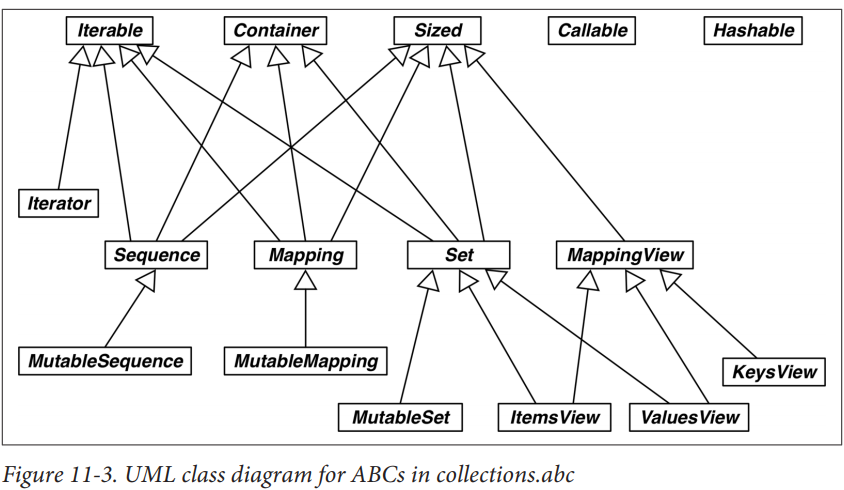

## 定義與使用 ABC
舉例 Tombola 做 ABC 範例 Tombloa 有四個方法其中
* 抽象方法
> * .load:將項目放進容器
> * .pick: 隨機從容器移除一個項目並回傳
* 具體方法
> * .loaded: 如果容器內有一個項目回傳 true
> * .inspect: 將容器內項目排序做成 tuple 並回傳

In [28]:
import abc

class Tombola(abc.ABC):  

    @abc.abstractmethod
    def load(self, iterable):  
        """Add items from an iterable."""

    @abc.abstractmethod
    def pick(self): 
        """Remove item at random, returning it.

        This method should raise `LookupError` when the instance is empty.
        """

    def loaded(self): 
        """Return `True` if there's at least 1 item, `False` otherwise."""
        return bool(self.inspect())  # <1>


    def inspect(self):
        """Return a sorted tuple with the items currently inside."""
        items = []
        while True:  # <2>
            try:
                items.append(self.pick())
            except LookupError:
                break
        self.load(items)  # <3>
        return tuple(sorted(items))


* inspect 不是好方法。但是說明可以透過 load pick 取容器值，跟放值來檢視 tombola 資料
1. loaded 代價很高因為呼叫 inspect 只是為了 套用 bool
2. 實作 inspect 需要捕捉 self.pick 丟出 LookupError,LookupError 是 Tombola.inspect 中處理例外
3. 使用 load 把所有東西放回去

In [32]:
class Fack(Tombola):
    def pick(self):
        return 13

In [33]:
Fack

__main__.Fack

In [34]:
f = Fack()

TypeError: Can't instantiate abstract class Fack with abstract methods load

## ABC 語法細節

## 繼承 Tombola ABC


In [35]:
import random

class BingoCage(Tombola):  

    def __init__(self, items):
        self._randomizer = random.SystemRandom()  
        self._items = []
        self.load(items)  # <1>

    def load(self, items):
        self._items.extend(items)
        self._randomizer.shuffle(self._items)  # <2>

    def pick(self):  # <3>
        try:
            return self._items.pop()
        except IndexError:
            raise LookupError('pick from empty BingoCage')

    def __call__(self):  # <4>
        self.pick()

1. 將初始化程序交給 load
2. 使用 SystemRandom 的 shuffle
3. pop items 裡面一個值，如果為空跳出訊息
4. __call__ 方法同 pick

In [36]:
class LotteryBlower(Tombola):

    def __init__(self, iterable):
        self._balls = list(iterable)  # <1>

    def load(self, iterable):
        self._balls.extend(iterable)

    def pick(self):
        try:
            position = random.randrange(len(self._balls))  # <2>
        except ValueError:
            raise LookupError('pick from empty BingoCage')
        return self._balls.pop(position)  # <3>

    def loaded(self):  # <4>
        return bool(self._balls)

    def inspect(self):  # <5>
        return tuple(sorted(self._balls))

1. 初始設定可接受任何迭代物
2. 如果範圍是空的把 valueError 改成 lookupError
3. 會從 self.balls 隨機取出項目
4. 用更好方法複寫 loadded 
5. 簡化方式複寫 inspect

## Tombola 虛擬子類別
藉由 register 方法來做，註冊類別就會被當成虛擬子類別。
用 issubclass 與 isinstance 視為如此，但是不會繼承 ABC 任何屬性

In [37]:
from random import randrange

@Tombola.register  # <1>
class TomboList(list):  # <2>

    def pick(self):
        if self:  # <3>
            position = randrange(len(self))
            return self.pop(position)  # <4>
        else:
            raise LookupError('pop from empty TomboList')

    load = list.extend  # <5>

    def loaded(self):
        return bool(self) 

    def inspect(self):
        return tuple(sorted(self))


1. TombolaList 被註冊為 Tombola 虛擬子類別
2. TombolaList 擴充 list
3. TombolaList 繼承 list __bool__ 如果不為空回傳 True
4. self.pop 是從 list 繼承
5. load 行為跟 list.extend 一樣


## 介紹測試 tombola 子類別


## 本章重點
* 非正式介面稱為協定
* 了解 ABC 靜態宣告並以 ABC 動態介面總結